<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
k-NN for Regression 
</p>

In [1]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# KNN + pipeline + preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

# Model selection & evaluation
from sklearn.model_selection import PredefinedSplit, learning_curve, cross_val_predict
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.covariance import LedoitWolf
from sklearn.decomposition import PCA

# Bayesian hyperparameter search
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# For the physics-consistency check
from scipy.stats import linregress

# For pretty display (as in your RF cell)
from IPython.display import display

# Housekeeping
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skopt')
warnings.filterwarnings("ignore", category=FutureWarning)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Load data & folds
</p>

In [ ]:
# Time-aware data load (from Data Preparation.ipynb outputs)

base_path = '../../Comprehensive ML - Files & Plots etc' 

df_train = pd.read_csv(f"{base_path}/train.csv", parse_dates=['time'])
df_test  = pd.read_csv(f"{base_path}/test.csv", parse_dates=['time'])
fold_assignments = np.load(f"{base_path}/train_folds.npy")

# Add log10(distance) (keep raw distance) and update features
#df_train["log_distance"] = np.log10(df_train["distance"].clip(lower=1))
#df_test["log_distance"] = np.log10(df_test["distance"].clip(lower=1))

feature_names = [
    "distance", "frequency", "c_walls", "w_walls", "co2",
    "humidity", "pm25", "pressure", "temperature", "snr"
]

X_train = df_train[feature_names].to_numpy()
y_train = df_train['PL'].to_numpy()
X_test  = df_test[feature_names].to_numpy()
y_test  = df_test['PL'].to_numpy()

time_train = df_train['time'].to_numpy()
time_test  = df_test['time'].to_numpy()

ps = PredefinedSplit(fold_assignments)  # reuse the time-aware folds

print(f"Train: {len(df_train)} rows, Test: {len(df_test)} rows")
print(f"Train window: {df_train.time.min()} -> {df_train.time.max()}")
print(f"Test window:  {df_test.time.min()} -> {df_test.time.max()}")

Train: 1663627 rows, Test: 415907 rows
Train window: 2024-10-01 00:01:07.420593+00:00 -> 2025-08-12 17:18:53.293125+00:00
Test window:  2025-08-12 17:19:02.126782+00:00 -> 2025-09-30 23:59:55.971870+00:00


In [3]:
# use a fraction of the data *per fold*. Set USE_SUBSET=False for full data.
USE_SUBSET = False
DATA_FRACTION = 0.25

if USE_SUBSET:
    fold_ids = np.unique(fold_assignments[fold_assignments != -1])
    keep_mask = np.zeros(len(df_train), dtype=bool)
    kept_counts = {}

    # keep the first DATA_FRACTION portion within each fold, preserving order
    for fid in fold_ids:
        idx = np.flatnonzero(fold_assignments == fid)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts[fid] = keep_n

    # (optional) if there are -1 labels in train, subset them too
    if np.any(fold_assignments == -1):
        idx = np.flatnonzero(fold_assignments == -1)
        keep_n = max(1, int(np.ceil(len(idx) * DATA_FRACTION)))
        keep_mask[idx[:keep_n]] = True
        kept_counts['-1'] = keep_n

    df_train = df_train.iloc[keep_mask].copy()
    fold_assignments = fold_assignments[keep_mask]
    # subset test set separately if you still want a fraction
    n_test = max(1, int(np.ceil(len(df_test) * DATA_FRACTION)))
    df_test = df_test.iloc[:n_test].copy()

    print("Using subset per fold:", kept_counts)
    print(f"Train rows kept: {len(df_train)}, Test rows kept: {len(df_test)}")
else:
    print("Using full dataset")

if len(df_train) == 0 or len(df_test) == 0:
    raise ValueError("Subset produced empty data; increase DATA_FRACTION or disable USE_SUBSET.")

# refresh arrays/split objects
X_train = df_train[feature_names].to_numpy()
y_train = df_train["PL"].to_numpy()
X_test = df_test[feature_names].to_numpy()
y_test = df_test["PL"].to_numpy()
time_train = df_train["time"].to_numpy()
time_test = df_test["time"].to_numpy()
ps = PredefinedSplit(fold_assignments)

fold_ids = fold_assignments[fold_assignments != -1]
print("Unique CV fold labels:", np.unique(fold_ids), "count:", np.unique(fold_ids).size)
print("Counts per fold:", np.bincount(fold_ids) if fold_ids.size else "none")

Using full dataset
Unique CV fold labels: [0 1 2 3 4] count: 5
Counts per fold: [554543 277271 277271 277271 277271]


In [4]:
# --- clamp n_neighbors to the smallest CV train size ---
test_folds = fold_assignments[fold_assignments != -1]
max_test_count = np.bincount(test_folds).max() if test_folds.size else 0
min_train_size = len(df_train) - max_test_count

orig_low, orig_high = 5, 60
clamped_high = max(orig_low, min(min_train_size, orig_high))
clamped_low = orig_low

class MahalanobisWhitening(BaseEstimator, TransformerMixin):
    """Shrinkage covariance -> whitening -> Euclidean == Mahalanobis distance."""
    def __init__(self, eps=1e-6): self.eps = eps
    def fit(self, X, y=None):
        cov = LedoitWolf().fit(X).covariance_
        eigvals, eigvecs = np.linalg.eigh(cov)
        self.W_ = eigvecs @ np.diag(1.0 / np.sqrt(np.clip(eigvals, self.eps, None))) @ eigvecs.T
        return self
    def transform(self, X):
        check_is_fitted(self, "W_")
        return X @ self.W_.T

def create_knn_pipeline():
    return Pipeline([
        ("power", "passthrough"),
        ("scaler", StandardScaler()),
        ("pca", "passthrough"),
        ("whitener", "passthrough"),
        ("knn", KNeighborsRegressor())
    ])

# --- clamp PCA choices to smallest train split ---
n_feats = X_train.shape[1]
max_pca = max(1, min(n_feats, min_train_size) - 1)
pca_choices = ["passthrough"] + [PCA(n_components=c) for c in (5, 10, 15) if c <= max_pca]
if len(pca_choices) == 1 and max_pca >= 2:
    pca_choices.append(PCA(n_components=max_pca))

search_spaces_knn = {
    "power": Categorical(["passthrough", PowerTransformer(method="yeo-johnson", standardize=False)]),
    "scaler": Categorical([StandardScaler(), RobustScaler()]),
    "pca": Categorical(pca_choices),
    "whitener": Categorical(["passthrough", MahalanobisWhitening()]),
    "knn__n_neighbors": Integer(clamped_low, clamped_high),
    "knn__weights": Categorical(["distance", "uniform"]),
    "knn__p": Real(1.0, 3.0, prior="uniform"),
    "knn__leaf_size": Integer(15, 80),
    "knn__metric": Categorical(["minkowski", "euclidean"]),
}

if clamped_high < orig_high:
    print(f"Clamped n_neighbors upper bound to {clamped_high} (smallest CV train fold).")

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
CV setup, Bayesian optimization, and CV summary per K
</p>

In [5]:
# ---- Multi-metric scoring ----
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# ---- PredefinedSplit (use provided fold assignments) ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization ----
bayes_cv_knn = BayesSearchCV(
    estimator=create_knn_pipeline(),
    search_spaces=search_spaces_knn,
    n_iter=70,   # more budget for larger space
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=8,
    cv=ps,
    random_state=42,
    verbose=2,
    n_points=4,
    optimizer_kwargs={'n_initial_points': 15, 'acq_func': 'gp_hedge'}
)

print(f"Starting Bayesian optimization with {bayes_cv_knn.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold CV per candidate...")

bayes_cv_knn.fit(X_train, y_train)

print("Bayesian optimization complete. Extracting results...")
bayes_results_knn = pd.DataFrame(bayes_cv_knn.cv_results_).copy()

cv_summary_per_k = []
if 'param_knn__n_neighbors' in bayes_results_knn.columns:
    bayes_results_knn['K'] = bayes_results_knn['param_knn__n_neighbors'].astype(int)
else:
    raise KeyError("BayesSearchCV results do not include 'param_knn__n_neighbors'.")

def name_step(step):
    if step == "passthrough":
        return "id"
    if isinstance(step, MahalanobisWhitening):
        return "mahal"
    if isinstance(step, PCA):
        return f"pca{step.n_components}"
    return step.__class__.__name__

for K in sorted(bayes_results_knn['K'].unique()):
    df_k = bayes_results_knn[bayes_results_knn['K'] == K]
    if df_k.empty:
        continue
    idx = df_k['mean_test_neg_root_mean_squared_error'].idxmax()
    best_row = df_k.loc[idx]

    best_rmse = -best_row['mean_test_neg_root_mean_squared_error']
    std_rmse = abs(best_row['std_test_neg_root_mean_squared_error'])
    best_cv_r2 = best_row['mean_test_r2']
    std_cv_r2 = best_row['std_test_r2']

    best_params = {k.replace('param_', ''): best_row[k] for k in df_k.columns if k.startswith('param_')}

    print(f"K={K:>3d} | Best CV RMSE: {best_rmse:.4f} | R²: {best_cv_r2:.4f} | "
          f"weights={best_params.get('knn__weights')}, p={best_params.get('knn__p')}, "
          f"metric={best_params.get('knn__metric')}, scaler={name_step(best_params.get('scaler'))}, "
          f"pca={name_step(best_params.get('pca'))}, whiten={name_step(best_params.get('whitener'))}")

    cv_summary_per_k.append({
        'K': K,
        'best_cv_rmse': best_rmse,
        'std_cv_rmse': std_rmse,
        'best_cv_r2': best_cv_r2,
        'std_cv_r2': std_cv_r2,
        'best_params': best_params
    })

cv_knn_df = pd.DataFrame(cv_summary_per_k)

Starting Bayesian optimization with 70 iterations and 5-fold CV per candidate...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END knn__leaf_size=42, knn__metric=euclidean, knn__n_neighbors=56, knn__p=1.6315991869740976, knn__weights=uniform, pca=PCA(n_components=5), power=passthrough, scaler=RobustScaler(), whitener=passthrough; total time=  19.2s
[CV] END knn__leaf_size=42, knn__metric=euclidean, knn__n_neighbors=56, knn__p=1.6315991869740976, knn__weights=uniform, pca=PCA(n_components=5), power=passthrough, scaler=RobustScaler(), whitener=passthrough; total time=  20.5s
[CV] END knn__leaf_size=42, knn__metric=euclidean, knn__n_neighbors=56, knn__p=1.6315991869740976, knn__weights=uniform, pca=PCA(n_components=5), power=passthrough, scaler=RobustScaler(), whitener=passthrough; total time=  21.2s
[CV] END knn__leaf_size=42, knn__metric=euclidean, knn__n_neighbors=56, knn__p=1.6315991869740976, knn__weights=uniform, pca=PCA(n_components=5), power=passthrough, scaler=

In [6]:
best_knn_model = bayes_cv_knn.best_estimator_
# CV predictions for train (avoids zero train RMSE due to self-neighbor)
y_train_cvpred = cross_val_predict(best_knn_model, X_train, y_train, cv=ps, n_jobs=8)
train_cv_rmse = np.sqrt(mean_squared_error(y_train, y_train_cvpred))

# Fit on full train, eval on held-out test
best_knn_model.fit(X_train, y_train)
y_test_pred = best_knn_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train CV RMSE (no self-neighbor): {train_cv_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")

Train CV RMSE (no self-neighbor): 6.2684
Test RMSE: 4.9497, Test R²: 0.9309


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plot: Best CV RMSE & its STD vs K
</p>

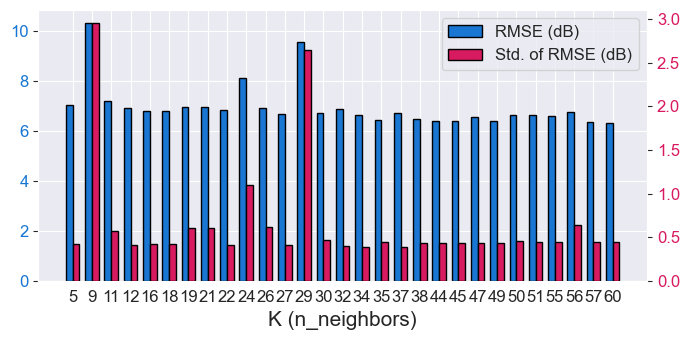

In [7]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12
axis_labelsize = 15
legend_fontsize = 12

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

# Sort by K for a clean x-axis
cv_knn_df = cv_knn_df.sort_values('K').reset_index(drop=True)

x = np.arange(len(cv_knn_df['K']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_knn_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
ax1.set_xlabel('K (n_neighbors)', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_knn_df['K'], fontsize=tick_fontsize, rotation=0)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_knn_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/KNN_bestRMSE_&_STD_perK.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plot: Best CV R² & its STD vs K
</p>

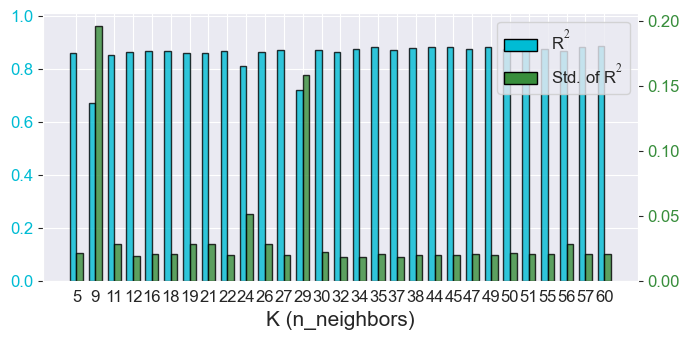

In [8]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12
axis_labelsize = 15
legend_fontsize = 12

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_knn_df['K']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Cyan bars: Best CV R² (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_knn_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('K (n_neighbors)', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_knn_df['K'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# Green bars: STD of CV R² (right y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_knn_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# Combined Legend
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
# plt.savefig('../../Comprehensive ML - Files & Plots etc/KNN_bestR2_STD_perK.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Train best KNN on full train set, evaluate on test, and save model
</p>

In [ ]:
# Use built-in best_estimator_ (already refitted on full train data) and best_params_
best_knn_model = bayes_cv_knn.best_estimator_
best_knn_params = bayes_cv_knn.best_params_
print("Best KNN Parameters Found:", best_knn_params)

print("\nUsing best KNN model from BayesSearchCV (already trained on all data)...")

y_train_pred = best_knn_model.predict(X_train)
y_test_pred  = best_knn_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)
train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

# Ensure the directory exists and save the trained KNN model
models_dir = '../Models'
os.makedirs(models_dir, exist_ok=True)

with open(os.path.join(models_dir, 'knn_final_model.pkl'), 'wb') as f:
    pickle.dump(best_knn_model, f)

print("Trained KNN model saved to ../Models/knn_final_model.pkl")

Best KNN Parameters Found: OrderedDict({'knn__leaf_size': 80, 'knn__metric': 'minkowski', 'knn__n_neighbors': 60, 'knn__p': 1.0, 'knn__weights': 'uniform', 'pca': 'passthrough', 'power': PowerTransformer(standardize=False), 'scaler': StandardScaler(), 'whitener': MahalanobisWhitening()})

Using best KNN model from BayesSearchCV (already trained on all data)...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),11.047062
1,Test Loss (MSE),24.499875
2,Test RMSE,4.949735
3,R² Score (Train),0.968796
4,R² Score (Test),0.930890
5,Test MAPE (%),4.418791
6,Test Median AE,2.950000


Trained KNN model saved to ../Models/knn_final_model.pkl


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Learning curve
</p>

In [ ]:
figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# Learning Curve (time-aware CV via PredefinedSplit)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_knn_model,
    X=X_train,
    y=y_train,
    cv=ps,  # use the predefined/time-aware folds
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='neg_root_mean_squared_error'
)

train_rmse = -train_scores.mean(axis=1)
test_rmse = -test_scores.mean(axis=1)

plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('KNN Learning Curve (time-aware CV)')
plt.legend()
# plt.savefig(f'{path}KNN_learning_curve.png', dpi=300)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Residuals 
</p>

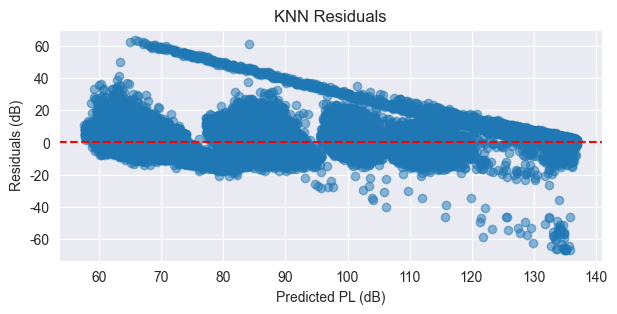

In [ ]:
y_test_pred = best_knn_model.predict(X_test)
residuals = y_test - y_test_pred

plt.figure(figsize=(7, 3))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('KNN Residuals')
# plt.savefig(f'{path}KNN_residuals.png', dpi=300)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Physics consistency: PL vs log10(distance)
</p>

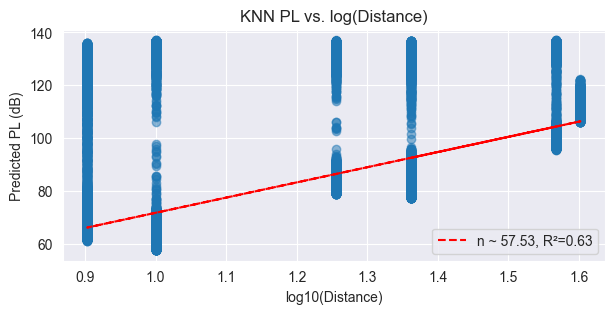

In [ ]:
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)  # guard against log(0)

slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)

plt.figure(figsize=(7, 3))
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--', 
         label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('KNN PL vs. log(Distance)')
plt.legend()
# plt.savefig(f'{path}KNN_physics_consistency.png', dpi=300)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Predicted vs Real
</p>

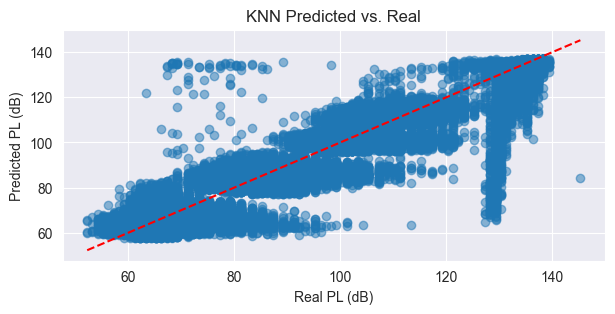

In [ ]:
plt.figure(figsize=(7, 3))
plt.scatter(y_test, y_test_pred, alpha=0.5)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('KNN Predicted vs. Real')
# plt.savefig(f'{path}KNN_pred_vs_real.png', dpi=300)
plt.show()